# Building a classifier to predict the churn in bank customers

### 0.1. Clear the cache

In [2]:
try:
    from IPython import get_ipython
    get_ipython().magic('clear')
    get_ipython().magic('reset -f')
except:
    pass

### 0.2. Import libraries

In [3]:
import pandas as pd
import numpy as np
import joblib

# standard Data Visualization libraries:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib 

import matplotlib.ticker as mtick
from IPython.display import display
from pandas.plotting import scatter_matrix
from sklearn.metrics import roc_curve

# sklearn modules for Data Preprocessing:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler

In [4]:
# advanced Data Visualization libraries:
import sweetviz as sv
import pandas_profiling as pp
from pandas_profiling import ProfileReport

In [5]:
# modules to use before modeling
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split

In [6]:
# sklearn modules for Model Selection:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [7]:
#sklearn modules for Model Evaluation & Improvement:
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score 
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, fbeta_score

In [8]:
# This is to supress the warning messages (if any) generated in our code:
import warnings
warnings.filterwarnings('ignore')

In [9]:
# Setting the seaborn style
sns.set(style="white")

In [129]:
# Setting the matplotlib style
parameters = {'axes.labelsize': 'medium',
              'axes.titlesize': 25,
              'xtick.labelsize': 15,
              'ytick.labelsize' : 15,
              'legend.fontsize' : 15,
              'legend.title_fontsize' : 20,
              'font.family' :  'sans-serif',
              'font.style' : "normal"}
plt.rcParams.update(parameters)

### 0.3 Functions

In [11]:
def initial_cleaning(df: pd.DataFrame) -> pd.DataFrame:
    """
    function for initial cleaning tasks like
    removing columns, duplicates etc.
    """
    # remove last 2 columns not needed for analysis
    df = df.iloc[: , :-2]
    
    return df

In [12]:
def handle_categorical_features(df : pd.DataFrame) -> pd.DataFrame:
    """
    function to encode categorical variables
    source : https://pbpython.com/categorical-encoding.html
    """

    # creating a column list for subset dataframe for categorical variables
    col_list = list(df.select_dtypes(include=['object']))
    
    # using Label encoding for columns with 2 or less unique categorical values
    le = LabelEncoder()
    le_list = []
    for col in col_list:
        if len(list(df[col].unique())) <= 2:
            le.fit(df[col])
            df[col] = le.transform(df[col])
            le_list.append(col)
            
            
       
    col_list = [i for i in col_list if i not in le_list]
            
    # using One Hot encoding for columns with 3 or more unique categorical values
    encoded_df = pd.get_dummies(df, columns= col_list, drop_first = True)
    
    return encoded_df

In [13]:
def calc_vif(X : pd.DataFrame) -> pd.DataFrame:
    """
    function to calculate VIF which is a measure of multicollinearity
    """
    
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    return vif
           

In [14]:
def feature_scaling(df : pd.DataFrame, method : str ) -> pd.DataFrame:
    """
    function to scale the given data as per method input
    """
    
    # choosing the scaler acc to input
    which_scaler = {
        "Standard": StandardScaler(),
        "Robust": RobustScaler()
       
    }
    scaler = which_scaler.get(method)
    
    # saving the scaled results in scaled_df
    df2 = pd.DataFrame(scaler.fit_transform(df))
    df2.columns = df.columns.values
    df2.index = df.index.values
    scaled_df = df2
    
    return scaled_df

In [15]:
def models_table(df : pd.DataFrame) -> pd.DataFrame:
    """
    function to study different classifers using the test dataset.
    a results table is returned for comparison.
    """    
    
    # Defining different Models to use for classification 
    models = []
    
    models.append(('Logistic Regression', LogisticRegression(solver='liblinear', random_state = 0,
                                                         class_weight='balanced')))
    models.append(('SVC', SVC(kernel = 'linear', random_state = 0)))
    models.append(('Kernel SVM', SVC(kernel = 'rbf', random_state = 0)))
    models.append(('KNN', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)))
    models.append(('Gaussian NB', GaussianNB()))
    models.append(('Decision Tree Classifier', DecisionTreeClassifier(criterion = 'entropy', random_state = 0)))
    models.append(('Random Forest', RandomForestClassifier(
                              n_estimators=100, criterion = 'entropy', random_state = 0)))
    
    #Evaluating Model Results:
    
    # set table to populate with performance results
    col = ['Algorithm', 'ROC AUC Mean', 'ROC AUC STD', 'Accuracy Mean', 'Accuracy STD']
    model_results = pd.DataFrame(columns=col)
    
    i = 0
    # Evaluate each model using k-fold cross-validation:
    for name, model in models:
        kfold = model_selection.KFold( n_splits=10)
        
        # accuracy scoring:
        cv_acc_results = model_selection.cross_val_score(model,df, y_train, cv=kfold, scoring='accuracy')
        
        # roc_auc scoring:
        cv_auc_results = model_selection.cross_val_score( model, df, y_train, cv=kfold, scoring='roc_auc')
        
        model_results.loc[i] = [name,
                                 round(cv_auc_results.mean()*100, 2),
                                 round(cv_auc_results.std()*100, 2),
                                 round(cv_acc_results.mean()*100, 2),
                                 round(cv_acc_results.std()*100, 2)
                                 ]
        i += 1
        
    # Showcasing the results table
    model_results.set_index('Algorithm',inplace=True ) 
    model_results = model_results.sort_values(by=['ROC AUC Mean'], ascending=False)
    
    return model_results

In [16]:
def parameter_finding(n : int) -> float:  
    """
    function to create a graph for different number of estimators
    returns the maximum score obtained
    """
    
    # finding optimal Random Forest parameter
    score_array = []
    
    for each in range(1,n):
        
        cl = RandomForestClassifier(n_estimators = each, random_state = 1)
        cl.fit(rs_X_train,y_train)
        
        score_array.append(cl.score(rs_X_test,y_test))

    # plotting the graph
    fig = plt.figure(figsize=(15, 7))
    plt.plot(range(1,n),score_array, color = '#ec838a')
    
    plt.ylabel('Score\n',horizontalalignment="center")
    plt.xlabel('Range\n',horizontalalignment="center")
    plt.title('Optimal Number of Random Forest Estimators \n')
    plt.legend(loc='upper right')
    
    plt.savefig('Estimator finding.png', bbox_inches='tight')
    plt.show()
    
    return round(max(score_array),5)

In [17]:
def models_table_tuned(df, df2, m, n):
    """
    function to see different impact of different hyperparameters
    """
    models = []
    models.append(('Logistic Regression', LogisticRegression(solver='liblinear', random_state = 0,
                                                         class_weight='balanced')))
    models.append(('SVC', SVC(kernel = 'linear', random_state = 0)))
    models.append(('Kernel SVM', SVC(kernel = 'rbf', random_state = 0)))
    models.append(('KNN', KNeighborsClassifier(n_neighbors = m, metric = 'minkowski', p = 2)))
    models.append(('Gaussian NB', GaussianNB()))
    models.append(('Decision Tree Classifier',
               DecisionTreeClassifier(criterion = 'entropy', random_state = 0)))
    models.append(('Random Forest', RandomForestClassifier(
       n_estimators=n, criterion = 'entropy', random_state = 0)))
    
    # Evaluating Model Results:
    acc_results, prec_results, rec_results, f1_results, f2_results  = ([] for i in range(5))

    auc_results = []
    names = []# set table to table to populate with performance results
    col = ['Algorithm', 'ROC AUC','Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score']
    
    model_results = pd.DataFrame(columns=col)
    i = 0
    
    for name, model in models:        
                
        # execute search
        model.fit(df, y_train)
        # get the best performing model fit on the whole training set
        #best_model = result.best_estimator_
        # evaluate model on the hold out dataset
        y_pred = model.predict(df2)
        
        # Evaluate results
        roc_auc = roc_auc_score(y_test, y_pred )
        acc = accuracy_score(y_test, y_pred )
        prec = precision_score(y_test, y_pred )
        rec = recall_score(y_test, y_pred )
        f1 = f1_score(y_test, y_pred )
        f2 = fbeta_score(y_test, y_pred, beta=2.0)
        
        model_results.loc[i] = [name,
                             round(roc_auc.mean()*100, 2),
                             
                             round(acc.mean()*100, 2),
                            
                             round(prec.mean()*100, 2),
                             round(rec.mean()*100, 2),
                             round(f1.mean()*100, 2),
                             round(f2.mean()*100, 2)
                             ]
        i += 1
        
    model_results.set_index('Algorithm', inplace=True) 
    model_results = model_results.sort_values(by=["Precision", "Recall", "F2 Score"], ascending=False)
    
    return model_results

In [18]:
def color_high_green(threshold : float):
    """
    function to highlight certain values
    """
    color = 'lightgreen' if threshold > round(95.50,2) else 'white'
    return 'background: %s' % color

In [72]:
def plotting_confusion_matrix(df : pd.DataFrame):
    """
    function to plot confusion matrix for given dataframe
    """
    plt.figure(figsize = (28,20))
    fig, ax = plt.subplots()
    sns.set(font_scale=1.0)
    sns.heatmap(df_cm, annot=True, fmt='g') 
    class_names=['Attrited','Existing']
    tick_marks = np.arange(len(class_names))
   
    plt.tight_layout();
    plt.title('Error matrix\n', y=1.1)
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    ax.xaxis.set_label_position("top")
    plt.ylabel('Actual label\n')
    plt.xlabel('Predicted label\n');
    
    plt.savefig('test confusion matrix.png');
    
    return ;

## 1. Getting started with bankchurners data

Data and information about data publicly available [here](https://www.kaggle.com/sakshigoyal7/credit-card-customers?select=BankChurners.csv)

### 1.1 Importing the data

In [20]:
# import data as pandas dataframe with CLIENTNUM as the index
df = pd.read_csv('BankChurners.csv',index_col = 0)

# looking at first few rows
df.head(2)

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
CLIENTNUM,,,,,,,,,,,,,,,,,,,,,
768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994


### 1.2 Data Exploration

In [21]:
# visual exploration using pandas profiling library
#profile = pp.ProfileReport(df, title = 'Profile Report : Bank Churners - Credit Card Data')
#profile.to_file('CC_pp_Analysis.html')

In [22]:
# visual exploration using sweetviz library
#my_report = sv.analyze(df)
#my_report.show_html('CC_sz_Analysis.html')

#### From the above two reports we gather that there are **No missing values, No duplicates, No Nan or null values**

   1. There are 16 categorical and 6 categorical variables.    
   
   
   2. Attrition Rate is the target or response variable and rest being the features.  
   
   
   3. Existing Customer 	8500 
      Attrited Customer 	1627  
      
      Female 5358 
      Male 4769 
      
      
   4. Most common values  

| Feature Name | Most Common Values |
| --- | --- |
| Customer Age | 40-50 |
| Dependent Count | 2 and 3 |
| Education Level | Graduate |
| Marital Status | Marital |
| Income Category | Less than 40K dollars |
| Card Category   | Blue |
| Months on Book  | 36 |
| Total_Relationship_Count | 3 |
| Months_Inactive_12_mon | 3 |
| Contacts_Count_12_mon | 2 and 3 |
| Credit_Limit | 1438.3 |
| Total_Trans_Amt | 3800 - 3900 |
| Avg_Utilization_Ratio | 2470 zeros |
      

 5. Correlation exists between certain features that will be studied later in detail

### 1.3 Detailed EDA

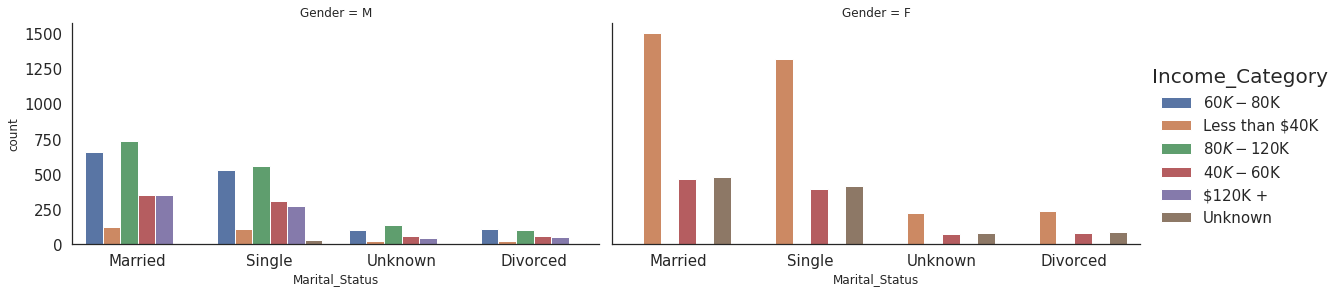

In [23]:
sns.catplot(x="Marital_Status", hue="Income_Category", col="Gender",

                data= df, kind="count",

                height=4, aspect=2);


plt.savefig('gender_income_marital', bbox_inches='tight')

In [24]:
not_attrited = df[df.Attrition_Flag != 'Attrited Customer']
not_attrited = not_attrited.drop(columns = 'Attrition_Flag')
not_attrited.head(2)

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
CLIENTNUM,,,,,,,,,,,,,,,,,,,,,
768805383,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
818770008,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994


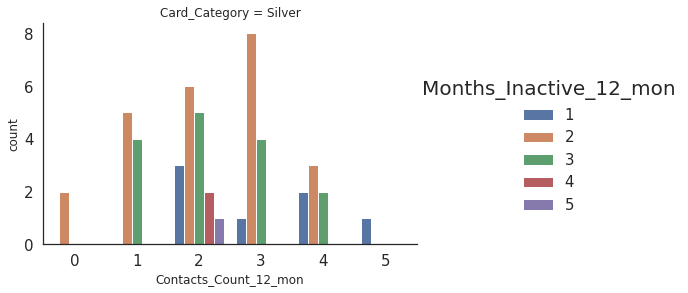

In [25]:
df_120 = not_attrited[not_attrited.Income_Category == '$120K +'  ]
df_120_silver = df_120[df_120.Card_Category == 'Silver'  ]
sns.catplot(x="Contacts_Count_12_mon", hue="Months_Inactive_12_mon", col="Card_Category",

                data= df_120_silver, kind="count",

                height=4, aspect=1.5);

### 1.4 Data Preprocessing

In [26]:
# perform basic cleaning on dataset to remove last 2 irrelevant columns
df = initial_cleaning(df)

# looking at first few rows
df.head(2)

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
CLIENTNUM,,,,,,,,,,,,,,,,,,,,
768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105


In [27]:
# encoding the categorical features
encoded_df = handle_categorical_features(df)

# looking at first few rows
encoded_df.head(2)

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,...,Marital_Status_Single,Marital_Status_Unknown,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
CLIENTNUM,,,,,,,,,,,,,,,,,,,,,
768805383,1,45,1,3,39,5,1,3,12691.0,777,...,0,0,0,1,0,0,0,0,0,0
818770008,1,49,0,5,44,6,1,2,8256.0,864,...,1,0,0,0,0,1,0,0,0,0


### 1.5 Preparing data for machine learning Removing multicollinearity

In [28]:
# dataframe containing features
X = encoded_df.drop('Attrition_Flag',axis=1) 

# the target
y = encoded_df['Attrition_Flag'] 



Now we ready to experiment with **Data Modeling**

## 2.Data Modeling

### 2.1 Splitting the dataset

In [29]:
# 80% of data is used for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### 2.2 Feature scaling

As all features are scaled differently, we need to scale them. 
This would help in finding the columns with high multicollinearity and then if needed remove those columns.

We here use the Robust method, as it is more suitable for our data

In [30]:
# first scaling training set
rs_X_train = feature_scaling(X_train, "Robust")

# now calculating vif for to look for features having strong multicollinearity 
calc_vif(rs_X_train)

,variables,VIF
0,Customer_Age,2.691664
1,Gender,3.499503
2,Dependent_count,1.046111
3,Months_on_book,2.662970
4,Total_Relationship_Count,1.152710
5,Months_Inactive_12_mon,1.014143
6,Contacts_Count_12_mon,1.041611
7,Credit_Limit,155955.113990
8,Total_Revolving_Bal,1065.569549
9,Avg_Open_To_Buy,155497.436149


In [31]:
# dropping columns that are highly collinear
ls = ["Total_Revolving_Bal","Avg_Open_To_Buy"]
rs_X_train = rs_X_train.drop(columns = ls)

# revalidate Colinearity
calc_vif(rs_X_train)

,variables,VIF
0,Customer_Age,2.695027
1,Gender,5.020821
2,Dependent_count,1.112309
3,Months_on_book,2.661908
4,Total_Relationship_Count,1.169076
5,Months_Inactive_12_mon,1.125928
6,Contacts_Count_12_mon,1.214482
7,Credit_Limit,2.780915
8,Total_Amt_Chng_Q4_Q1,1.199444
9,Total_Trans_Amt,3.350817


In [32]:
# replicating the exact process on test set
rs_X_test = feature_scaling(X_test, "Robust")
rs_X_test = rs_X_test.drop(columns = ls)

# revalidated colinearity and all is aligned.

### 2.3 Model Comparison

We will see below the comparison of results from different classifiers 

In [33]:
# calling function to build models
models_table(rs_X_train)

,ROC AUC Mean,ROC AUC STD,Accuracy Mean,Accuracy STD
Algorithm,,,,
Random Forest,98.85,0.38,95.88,0.76
Kernel SVM,96.21,1.02,93.12,0.95
Logistic Regression,91.86,0.92,83.64,1.31
SVC,91.35,0.98,89.90,1.20
KNN,89.20,2.00,90.04,0.96
Decision Tree Classifier,88.19,1.62,93.80,0.79
Gaussian NB,84.73,1.53,87.43,1.18


### 2.4 Optimizing parameters for baseline models

We see that Random Forest Classifier provides the best result and we will try to finetune the hyperparameters.

No handles with labels found to put in legend.


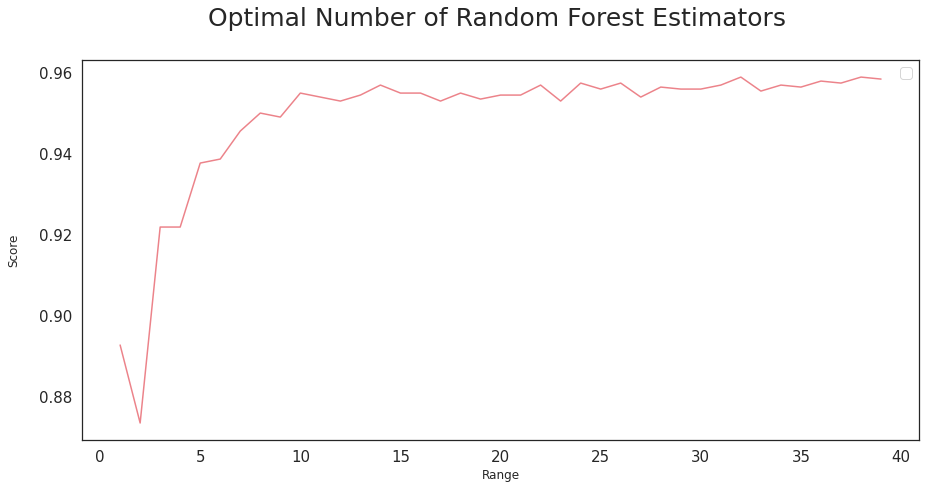

0.95903

In [34]:
# graphically checking the impact of varying number of estimators(trees) in the random forest
parameter_finding(40)

### 2.5 More evaluation of different models

In [35]:
model_results = models_table_tuned(rs_X_train,rs_X_test, 5, 15)
model_results.style.applymap(color_high_green)

,ROC AUC,Accuracy,Precision,Recall,F1 Score,F2 Score
Algorithm,,,,,,
Logistic Regression,83.260000,82.870000,96.600000,82.700000,89.110000,85.150000
Decision Tree Classifier,88.460000,93.930000,96.500000,96.330000,96.420000,96.360000
Random Forest,85.870000,94.720000,95.330000,98.600000,96.940000,97.930000
Kernel SVM,83.740000,93.580000,94.700000,97.900000,96.280000,97.250000
Gaussian NB,78.180000,87.760000,93.490000,91.960000,92.720000,92.260000
SVC,75.750000,89.930000,92.290000,96.160000,94.180000,95.360000
KNN,74.870000,90.470000,91.910000,97.320000,94.540000,96.190000


### By observations above, Random Forest is the best performing overall

## 3.Model Evaluation of Random Forest

### 3.1 Kfold cross validation for this chosen model

In [36]:
# Fitting Random Forest to the Training set:
    
classifier = RandomForestClassifier(n_estimators = 15,bootstrap = True,
                               max_features = 'sqrt', criterion = 'entropy', random_state = 0)
classifier.fit(rs_X_train, y_train)

# Predicting the Test set results 
y_pred = classifier.predict(rs_X_test)

#Evaluate Model Results on Test Set:
acc = accuracy_score(y_test, y_pred )
prec = precision_score(y_test, y_pred )
rec = recall_score(y_test, y_pred )
f1 = f1_score(y_test, y_pred )
f2 = fbeta_score(y_test, y_pred, beta=2.0)

results = pd.DataFrame([['Random Forest Classifier',acc, prec, rec, f1, f2]],
                       columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score'])
results.set_index('Model', inplace = True)

results

,Accuracy,Precision,Recall,F1 Score,F2 Score
Model,,,,,
Random Forest Classifier,0.947187,0.953266,0.986022,0.969367,0.979292


In [37]:
accuracies = cross_val_score(estimator = classifier, X = rs_X_train, y = y_train, cv = 10)
print("Random Forest Classifier Accuracy: %0.2f (+/- %0.2f)"  % (accuracies.mean(), accuracies.std() * 2))

Random Forest Classifier Accuracy: 0.95 (+/- 0.02)


### 3.2 Confusion matrix

<Figure size 2016x1440 with 0 Axes>

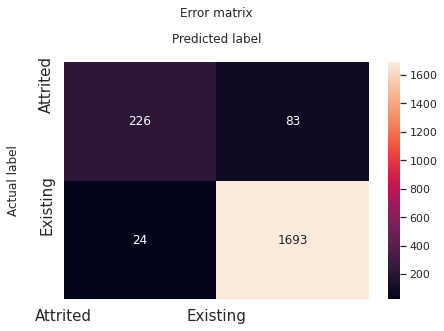

In [130]:
#create a confusion matrix for test data
cm = confusion_matrix(y_test, y_pred) 
df_cm = pd.DataFrame(cm, index = ('Attrited','Existing'), columns = ('Attrited','Existing'))

# plotting
plotting_confusion_matrix(df_cm)

Text(0.5, 0.98, 'Testing Data Confusion Matrix')

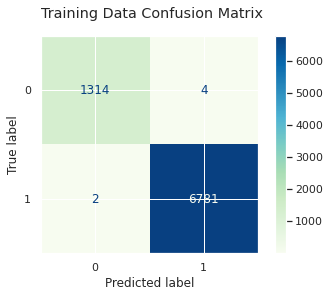

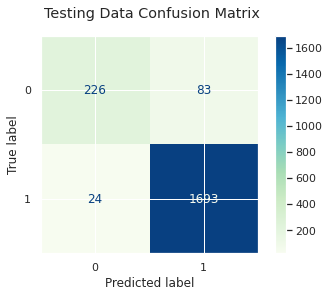

In [39]:
# plotting the confusion matrix for train and test data

disp = plot_confusion_matrix(classifier, rs_X_train, y_train, cmap = "GnBu" )
disp.figure_.suptitle("Training Data Confusion Matrix")


disp = plot_confusion_matrix(classifier, rs_X_test, y_test, cmap = "GnBu" )
disp.figure_.suptitle("Testing Data Confusion Matrix")

In [40]:
# detailed clasification report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.73      0.81       309
           1       0.95      0.99      0.97      1717

    accuracy                           0.95      2026
   macro avg       0.93      0.86      0.89      2026
weighted avg       0.95      0.95      0.94      2026



### 3.3 ROC curve

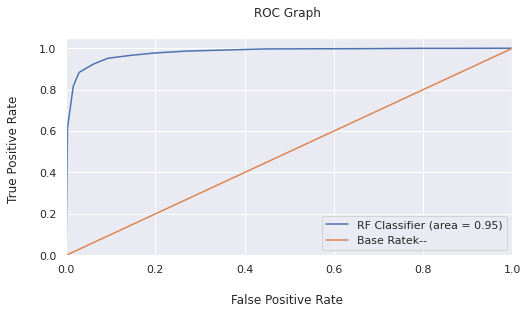

In [41]:
classifier.fit(rs_X_train, y_train) 
probs = classifier.predict_proba(rs_X_test) 

probs = probs[:, 1] 
classifier_roc_auc = accuracy_score(y_test, y_pred )
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, classifier.predict_proba(rs_X_test)[:,1])
plt.figure(figsize=(8,4))

# Plot Logistic Regression ROC
plt.plot(rf_fpr, rf_tpr, label='RF Classifier (area = %0.2f)' % classifier_roc_auc)

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.ylabel('True Positive Rate \n')
plt.xlabel('\nFalse Positive Rate \n')
plt.title('ROC Graph \n')

plt.legend(loc="lower right")
plt.savefig('roc graph.png', dpi=100)
plt.show()

### 3.4 Feature Importance

In [42]:
# view the feature scores
feature_scores = pd.Series(classifier.feature_importances_, index=rs_X_train.columns).sort_values(ascending=False)

# most important features
feature_scores.nlargest()

Total_Trans_Ct           0.206283
Total_Trans_Amt          0.183551
Avg_Utilization_Ratio    0.108199
Total_Ct_Chng_Q4_Q1      0.090711
Total_Amt_Chng_Q4_Q1     0.074110
dtype: float64

In [43]:
# least important features
feature_scores.nsmallest()

Card_Category_Platinum       0.000144
Card_Category_Gold           0.001041
Education_Level_Doctorate    0.001794
Marital_Status_Unknown       0.002466
Card_Category_Silver         0.002846
dtype: float64

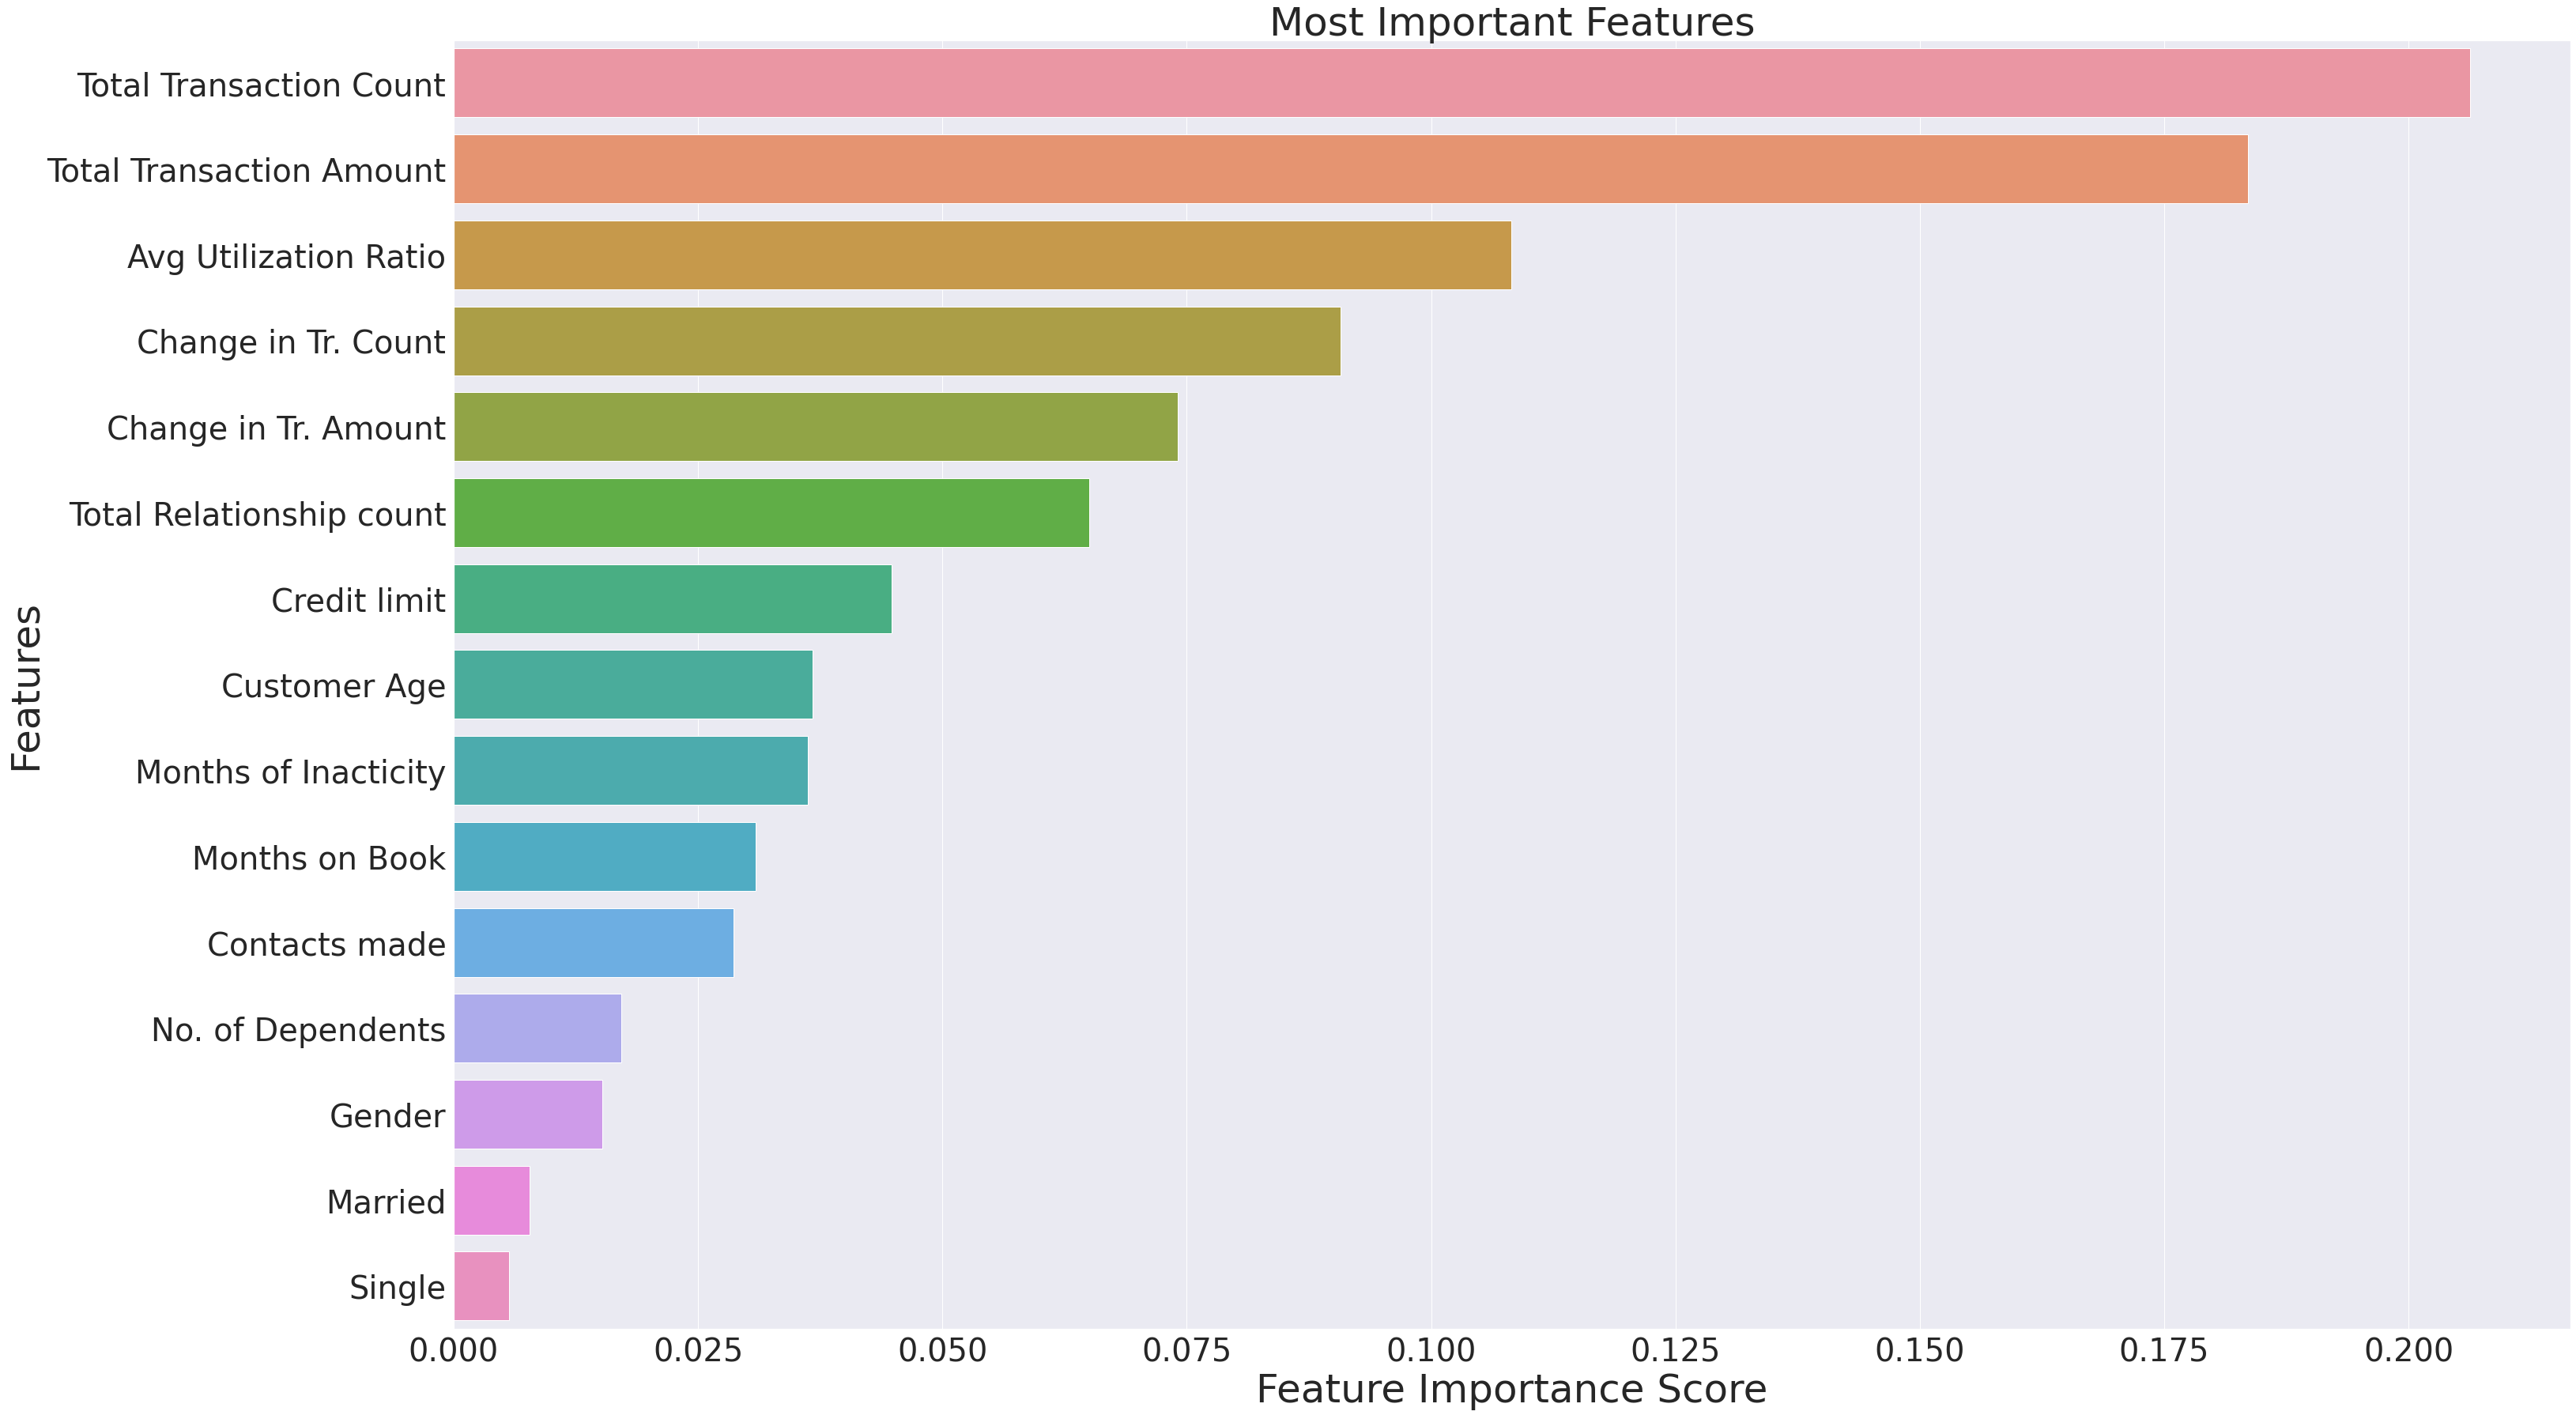

In [127]:
plt.figure(figsize=(48,30))
g = sns.barplot(x=feature_scores.nlargest(15), y=feature_scores.nlargest(15).index)
g.set_yticklabels(['Total Transaction Count','Total Transaction Amount','Avg Utilization Ratio',
                   'Change in Tr. Count','Change in Tr. Amount','Total Relationship count',
                  'Credit limit', 'Customer Age','Months of Inacticity', 'Months on Book',
                  'Contacts made', 'No. of Dependents','Gender', 'Married', 'Single'])

# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')

# Add title to the graph
plt.title("Most Important Features")

# Visualize the graph
plt.savefig('imp features.png');
plt.show()

## 4.Final Results

### 4.1 Here we will do the **Risk Profiling** of the client

In [45]:
#getting the CLIENTNUM
train_identity = rs_X_train.index.astype(int)
test_identity = pd.Series(rs_X_test.index.values)

In [46]:
# geenrating final results data frame for the test data

final_results = y_test.to_frame()

final_results['predictions'] = y_pred

final_results["propensity_to_retain(%)"] = probs*100 
final_results["propensity_to_retain(%)"] = final_results["propensity_to_retain(%)"].round(2)

#final_results['Ranking'] = pd.qcut(final_results['propensity_to_churn(%)'].rank(method = 'first'),10,labels=range(10,0,-1))

# create a list of our conditions
conditions = [
    (final_results["propensity_to_retain(%)"]  <= 25),
    (final_results["propensity_to_retain(%)"] > 25) & (final_results["propensity_to_retain(%)"] <= 50),
    (final_results["propensity_to_retain(%)"] > 50) & (final_results["propensity_to_retain(%)"] <= 75),
    (final_results["propensity_to_retain(%)"]  > 75)
    ]
    
# create a list of the values we want to assign for each condition
values = ['Very High', 'High', 'Medium', 'Low']

# create a new column and use np.select to assign values to it using our lists as arguments
final_results['Risk of Attrition'] = np.select(conditions, values)

final_results.head()

,Attrition_Flag,predictions,propensity_to_retain(%),Risk of Attrition
CLIENTNUM,,,,
818903583,1,1,100.0,Low
715150983,0,0,0.0,Very High
789180933,1,1,100.0,Low
717667833,1,1,100.0,Low
714745608,1,1,80.0,Low


In [47]:
# exporting final classification result for test set to csv file
final_results.to_csv(r'final_classification_result.csv', header = True)


### 4.2 Digging deeper based on Propensity to retain

In [59]:
# looking at number of clients in each % group
final_results_retain = final_results.groupby(by=["propensity_to_retain(%)"]).count()
final_results_retain['Number of Customers'] = final_results_retain.predictions
final_results_retain.drop(columns = ['Attrition_Flag','predictions','Risk of Attrition'], inplace = True)
final_results_retain.to_csv(r'final_classification_clients_that_retain.csv', header = True)
final_results_retain

,Number of Customers
propensity_to_retain(%),
0.00,39
6.67,26
13.33,47
20.00,38
26.67,27
33.33,25
40.00,20
46.67,28
53.33,38


In [49]:
# looking at number of clients in each risk group
final_results_riskwise = final_results.groupby(by=["Risk of Attrition"]).count()

reorderlist = ['Very High', 'High', 'Medium', 'Low']
final_results_riskwise = final_results_riskwise.reindex(reorderlist)

final_results_riskwise

,Attrition_Flag,predictions,propensity_to_retain(%)
Risk of Attrition,,,
Very High,150,150,150
High,100,100,100
Medium,171,171,171
Low,1605,1605,1605


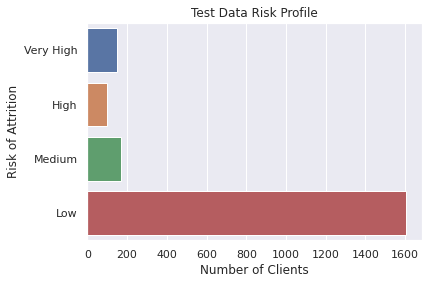

In [75]:
sns.barplot(x=final_results_riskwise.predictions, y=final_results_riskwise.index, data=final_results_riskwise)

# Add labels to the graph
plt.xlabel('Number of Clients')
plt.ylabel('Risk of Attrition')

# Add title to the graph
plt.title("Test Data Risk Profile")

# Visualize the graph
plt.savefig('Test_Data_Risk_Profile.png', bbox_inches='tight')
plt.show()


### 4.3 Looking at predictions that were not right


In [99]:
# mismatch is data frame for type I and type II errors
mismatch = final_results.loc[final_results.Attrition_Flag != final_results.predictions ]
mismatch = mismatch.sort_values( by = ['propensity_to_retain(%)'])


mismatch.head(47)

,Attrition_Flag,predictions,propensity_to_retain(%),Risk of Attrition
CLIENTNUM,,,,
719621958,1,0,0.00,Very High
814459833,1,0,13.33,Very High
803776533,1,0,13.33,Very High
787541883,1,0,13.33,Very High
710641008,1,0,20.00,Very High
712571883,1,0,26.67,High
779743908,1,0,33.33,High
719466558,1,0,33.33,High
709693833,1,0,33.33,High


In [102]:
mismatch = mismatch[mismatch.predictions == 1]
mismatch

,Attrition_Flag,predictions,propensity_to_retain(%),Risk of Attrition
CLIENTNUM,,,,
720590058,0,1,53.33,Medium
714789033,0,1,53.33,Medium
787460883,0,1,53.33,Medium
711745233,0,1,53.33,Medium
720983733,0,1,53.33,Medium
...,...,...,...,...
719146008,0,1,93.33,Low
711684408,0,1,93.33,Low
803800533,0,1,93.33,Low


In [92]:
# detailed profiling

mismatch = mismatch.groupby(by=[ "Risk of Attrition"]).count()
mismatch['Number of Customers']=mismatch.predictions
mismatch.drop(columns = ['Attrition_Flag','predictions', 'propensity_to_retain(%)'], inplace = True)



In [95]:

mismatch.to_csv(r'mismatch.csv', header = True)
mismatch

,Number of Customers
Risk of Attrition,
High,19
Low,19
Medium,64
Very High,5


## 5.Preparing for Deployment

In [53]:
# saving the classifier for use in deployment
filename = 'final_model.model'
i = [classifier]
joblib.dump(i,filename)

['final_model.model']

## Future Analysis


More Specific Analyis based on Risk groups, Age etc needs to be done. 
Profile of Clients who were most likely to be mismatched need to be studied and special attention to be paid to them.